In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-prediction-using-logistic-regression/framingham.csv


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statistics import mean,stdev
from numpy import arange
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Loading, Understanding and Preparing Data

In [3]:
df = pd.read_csv('../input/heart-disease-prediction-using-logistic-regression/framingham.csv')
df.head(20)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [4]:
df.shape

(4238, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [6]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [7]:
df.dtypes

male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [8]:
# Checking unique values in each column
df.nunique()

male                  2
age                  39
education             4
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             248
sysBP               234
diaBP               146
BMI                1363
heartRate            73
glucose             143
TenYearCHD            2
dtype: int64

<AxesSubplot:ylabel='count'>

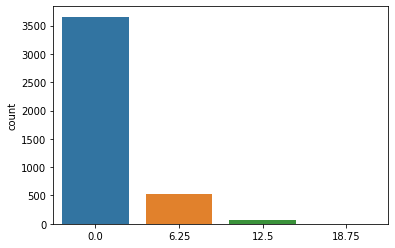

In [9]:
# Checking null values in Rows
sns.countplot((100*(df.isnull().sum(axis = 1) / df.shape[1])).round(2).sort_values(ascending = False))

**Since we have only 16 columns, I will set the threshold as minimum 15 columns should be Not Null**

<AxesSubplot:ylabel='count'>

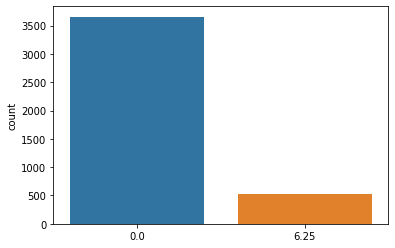

In [10]:
# Droppping rows which has less than 15 not null entries
df = df.dropna(axis = 0, thresh = 15)
sns.countplot((100*(df.isnull().sum(axis = 1) / df.shape[1])).round(2).sort_values(ascending = False))

In [11]:
df.shape

(4177, 16)

In [12]:
# Checking null values in Columns
(100*(df.isnull().sum() / df.shape[0])).round(2).sort_values(ascending = False) 

glucose            7.92
education          2.23
BPMeds             1.22
cigsPerDay         0.55
BMI                0.31
totChol            0.22
heartRate          0.02
male               0.00
age                0.00
currentSmoker      0.00
prevalentStroke    0.00
prevalentHyp       0.00
diabetes           0.00
sysBP              0.00
diaBP              0.00
TenYearCHD         0.00
dtype: float64

**Not much NaNs - Column-wise. We have to impute them**

In [13]:
columns_to_be_imputed = []
for i in df.columns:
    null_percent = (100*(df[i].isnull().sum() / df.shape[0]))
    if(null_percent > 0):
        columns_to_be_imputed.append(i)

columns_to_be_imputed

['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate', 'glucose']

array([[<AxesSubplot:title={'center':'male'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'currentSmoker'}>],
       [<AxesSubplot:title={'center':'cigsPerDay'}>,
        <AxesSubplot:title={'center':'BPMeds'}>,
        <AxesSubplot:title={'center':'prevalentStroke'}>,
        <AxesSubplot:title={'center':'prevalentHyp'}>],
       [<AxesSubplot:title={'center':'diabetes'}>,
        <AxesSubplot:title={'center':'totChol'}>,
        <AxesSubplot:title={'center':'sysBP'}>,
        <AxesSubplot:title={'center':'diaBP'}>],
       [<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'heartRate'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'TenYearCHD'}>]], dtype=object)

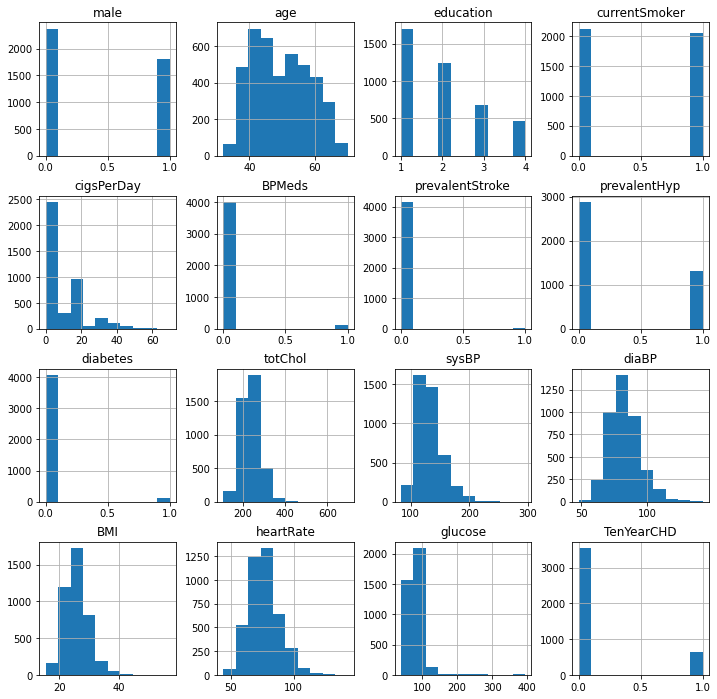

In [14]:
# Seeing distributions of all the features before imputing missing values
df.hist(figsize=(12,12))

**Most of the columns are skewed, so we have to impute using Mode**

In [15]:
# Separating Numerical and Categorical Features 
numeric_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
categoric_features = ['male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [16]:
#Imputing Features
for i in columns_to_be_imputed:
    df[i] = df[i].fillna(df[i].mode()[0])

In [17]:
# Checking null values in Columns
(100*(df.isnull().sum() / df.shape[0])).round(2).sort_values(ascending = False) 

male               0.0
age                0.0
education          0.0
currentSmoker      0.0
cigsPerDay         0.0
BPMeds             0.0
prevalentStroke    0.0
prevalentHyp       0.0
diabetes           0.0
totChol            0.0
sysBP              0.0
diaBP              0.0
BMI                0.0
heartRate          0.0
glucose            0.0
TenYearCHD         0.0
dtype: float64

In [18]:
# Calculating Skewness and Kurtosis of the inputs
def checking_skew(dff):
    sk = skew(dff[numeric_features])
    skew_df = pd.DataFrame()
    skew_df['Columns'] = numeric_features
    skew_df['Skew'] = sk
    skew_df['IsSkewed'] = np.absolute(sk > 1)
    print(skew_df)

In [19]:
checking_skew(df)

      Columns      Skew  IsSkewed
0         age  0.230157     False
1  cigsPerDay  1.260163      True
2     totChol  0.870447     False
3       sysBP  1.149838      True
4       diaBP  0.716054     False
5         BMI  0.994711     False
6   heartRate  0.647064     False
7     glucose  6.478848      True


**Glucose, sysBP, cigsPerDay are skewed. We have to correct it**

In [20]:
df=df[df.glucose<np.nanpercentile(df['glucose'], 98.5)]
df=df[df.cigsPerDay<np.nanpercentile(df['cigsPerDay'], 98.5)]
df=df[df.sysBP<np.nanpercentile(df['sysBP'], 99)]
checking_skew(df)

      Columns      Skew  IsSkewed
0         age  0.245613     False
1  cigsPerDay  1.040527      True
2     totChol  0.786777     False
3       sysBP  0.777044     False
4       diaBP  0.508029     False
5         BMI  0.970002     False
6   heartRate  0.659429     False
7     glucose  1.015338      True


**Now Almost all the features are Moderately skewed, which is fine**

**Education and BPMeds are in Categorical Float, should change them to int64**

In [21]:
# Converting education and BPMeds from float to int
print(df['education'])
print(df['BPMeds'])

0       4.0
1       2.0
2       1.0
3       3.0
4       3.0
       ... 
4232    1.0
4233    1.0
4235    2.0
4236    1.0
4237    2.0
Name: education, Length: 3995, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4232    0.0
4233    0.0
4235    0.0
4236    0.0
4237    0.0
Name: BPMeds, Length: 3995, dtype: float64


In [22]:
df['education'] = df['education'].astype('int64')
df['BPMeds'] = df['education'].astype('int64')

In [23]:
# Converting Categorical Numeric Values to type category
for i in categoric_features:
    df[i] = df[i].astype('category')

In [24]:
df.dtypes

male               category
age                   int64
education          category
currentSmoker      category
cigsPerDay          float64
BPMeds             category
prevalentStroke    category
prevalentHyp       category
diabetes           category
totChol             float64
sysBP               float64
diaBP               float64
BMI                 float64
heartRate           float64
glucose             float64
TenYearCHD            int64
dtype: object

In [25]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4,0,0.0,4,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2,0,0.0,2,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,1,20.0,1,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3,1,30.0,3,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3,1,23.0,3,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [26]:
dummy = pd.get_dummies(df[categoric_features], drop_first=True)
dummy.head()

,male_1,education_2,education_3,education_4,currentSmoker_1,BPMeds_2,BPMeds_3,BPMeds_4,prevalentStroke_1,prevalentHyp_1,diabetes_1
0,1,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,0,1,0
4,0,0,1,0,1,0,1,0,0,0,0


In [27]:
df1 = df.drop(categoric_features, axis = 1)

In [28]:
df1 = pd.concat([df1, dummy], axis = 1)
df1.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,male_1,education_2,education_3,education_4,currentSmoker_1,BPMeds_2,BPMeds_3,BPMeds_4,prevalentStroke_1,prevalentHyp_1,diabetes_1
0,39,0.0,195.0,106.0,70.0,26.97,80.0,77.0,0,1,0,0,1,0,0,0,1,0,0,0
1,46,0.0,250.0,121.0,81.0,28.73,95.0,76.0,0,0,1,0,0,0,1,0,0,0,0,0
2,48,20.0,245.0,127.5,80.0,25.34,75.0,70.0,0,1,0,0,0,1,0,0,0,0,0,0
3,61,30.0,225.0,150.0,95.0,28.58,65.0,103.0,1,0,0,1,0,1,0,1,0,0,1,0
4,46,23.0,285.0,130.0,84.0,23.10,85.0,85.0,0,0,0,1,0,1,0,1,0,0,0,0


In [29]:
df1.columns

Index(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate',
       'glucose', 'TenYearCHD', 'male_1', 'education_2', 'education_3',
       'education_4', 'currentSmoker_1', 'BPMeds_2', 'BPMeds_3', 'BPMeds_4',
       'prevalentStroke_1', 'prevalentHyp_1', 'diabetes_1'],
      dtype='object')

In [30]:
df1.shape

(3995, 20)

# EDA

In [31]:
# Plotting Categorical Features
def plotting_cat_features(df, cols):
    for i in cols:
        plt.figure(figsize=(15,5))
        sns.countplot(df[i], hue = df['TenYearCHD'])
        plt.title(i.upper(), fontsize=18, color="indigo")
        plt.show()

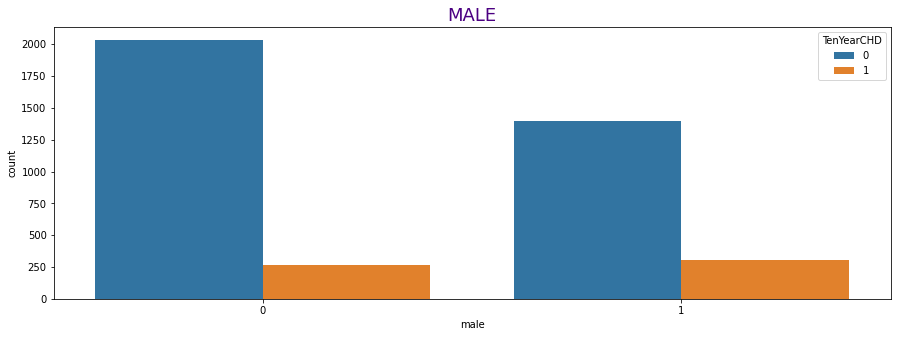

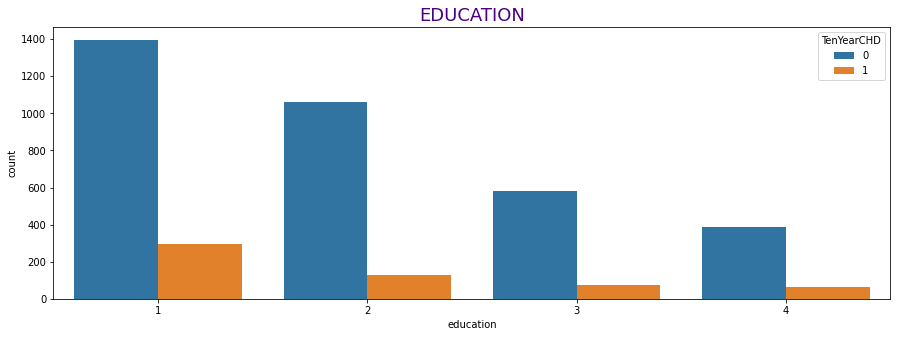

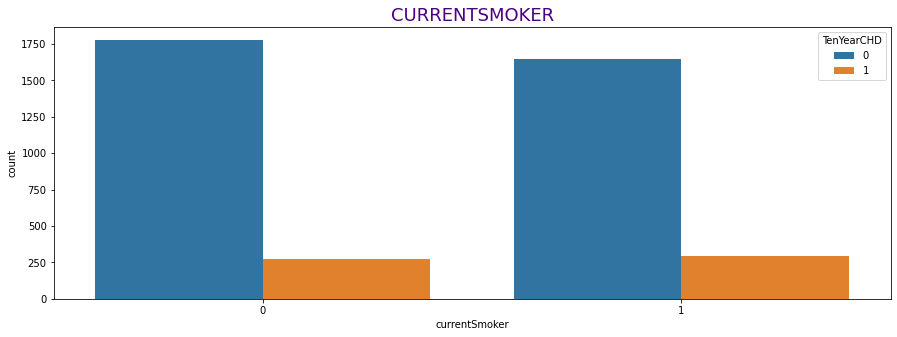

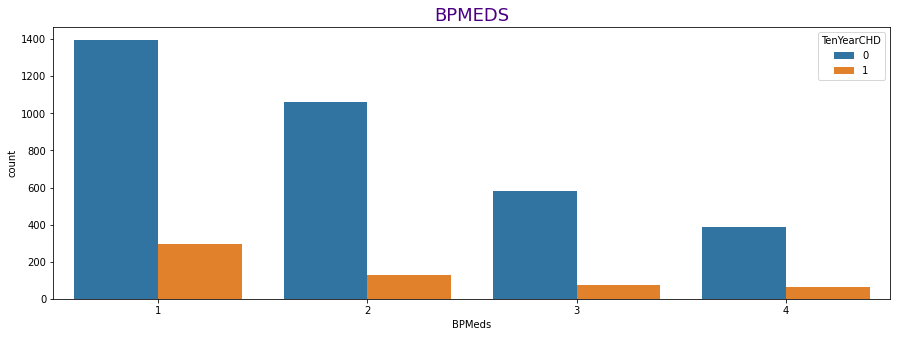

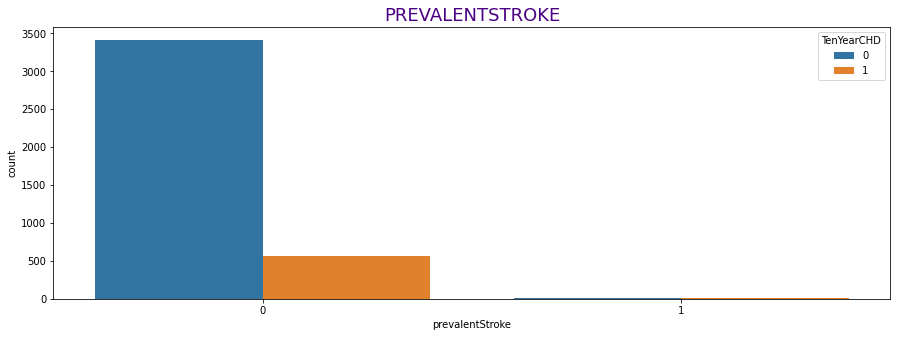

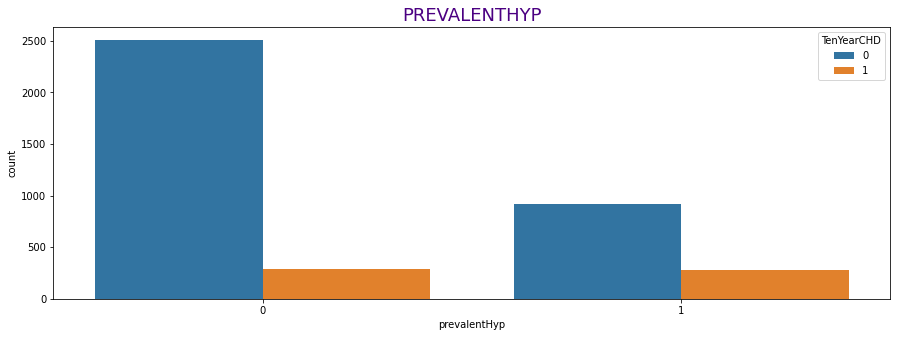

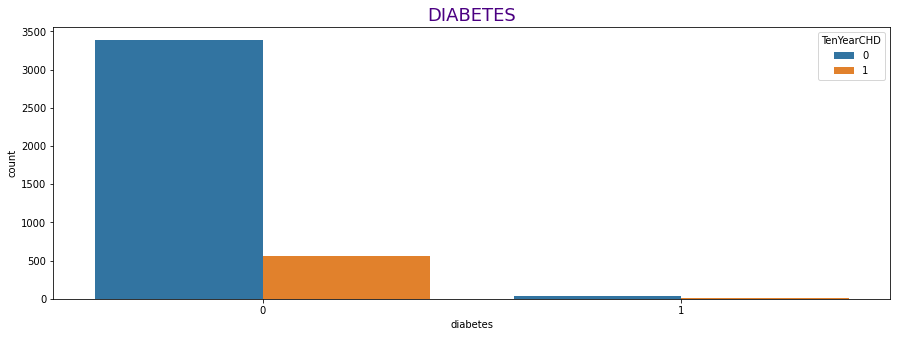

In [32]:
plotting_cat_features(df, categoric_features)

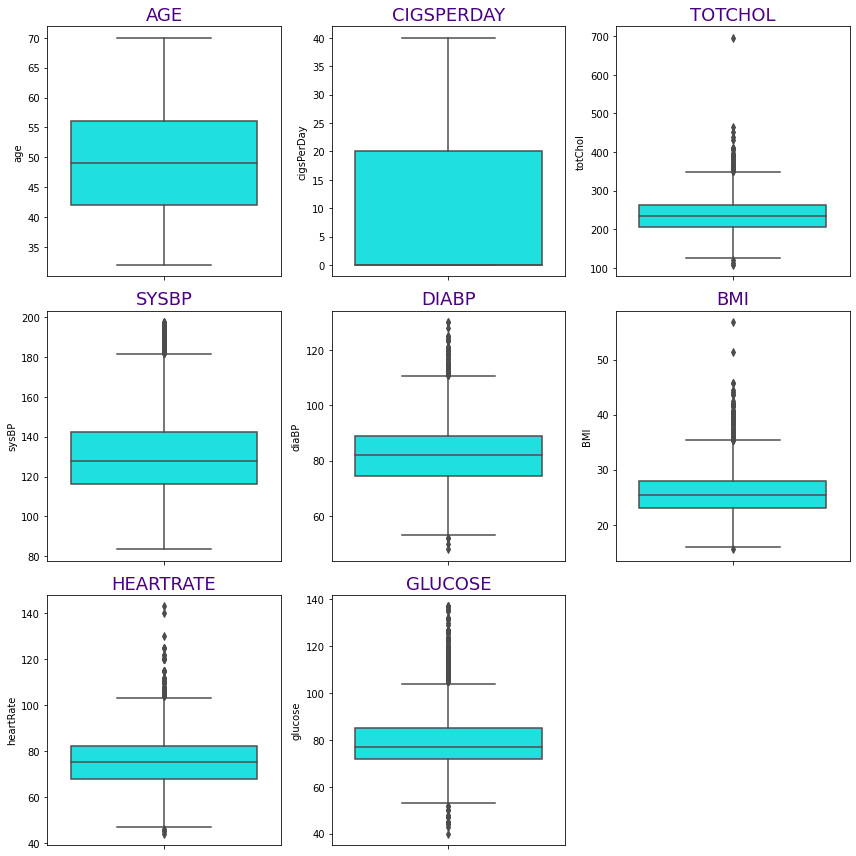

In [33]:
#Plotting Numerical Features

plt.figure(figsize=(12,12))
i = 1
for c in numeric_features:
    plt.subplot(3,3,i)
    sns.boxplot(y = c, data = df, color='cyan')
    plt.title(c.upper(), fontsize=18, color="indigo")
    i = i+1
    plt.tight_layout()

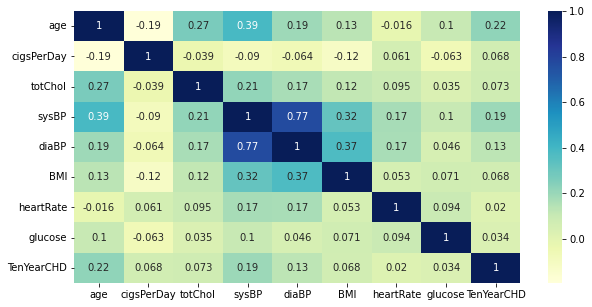

In [34]:
#Plotting Correlation
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True)
plt.show()

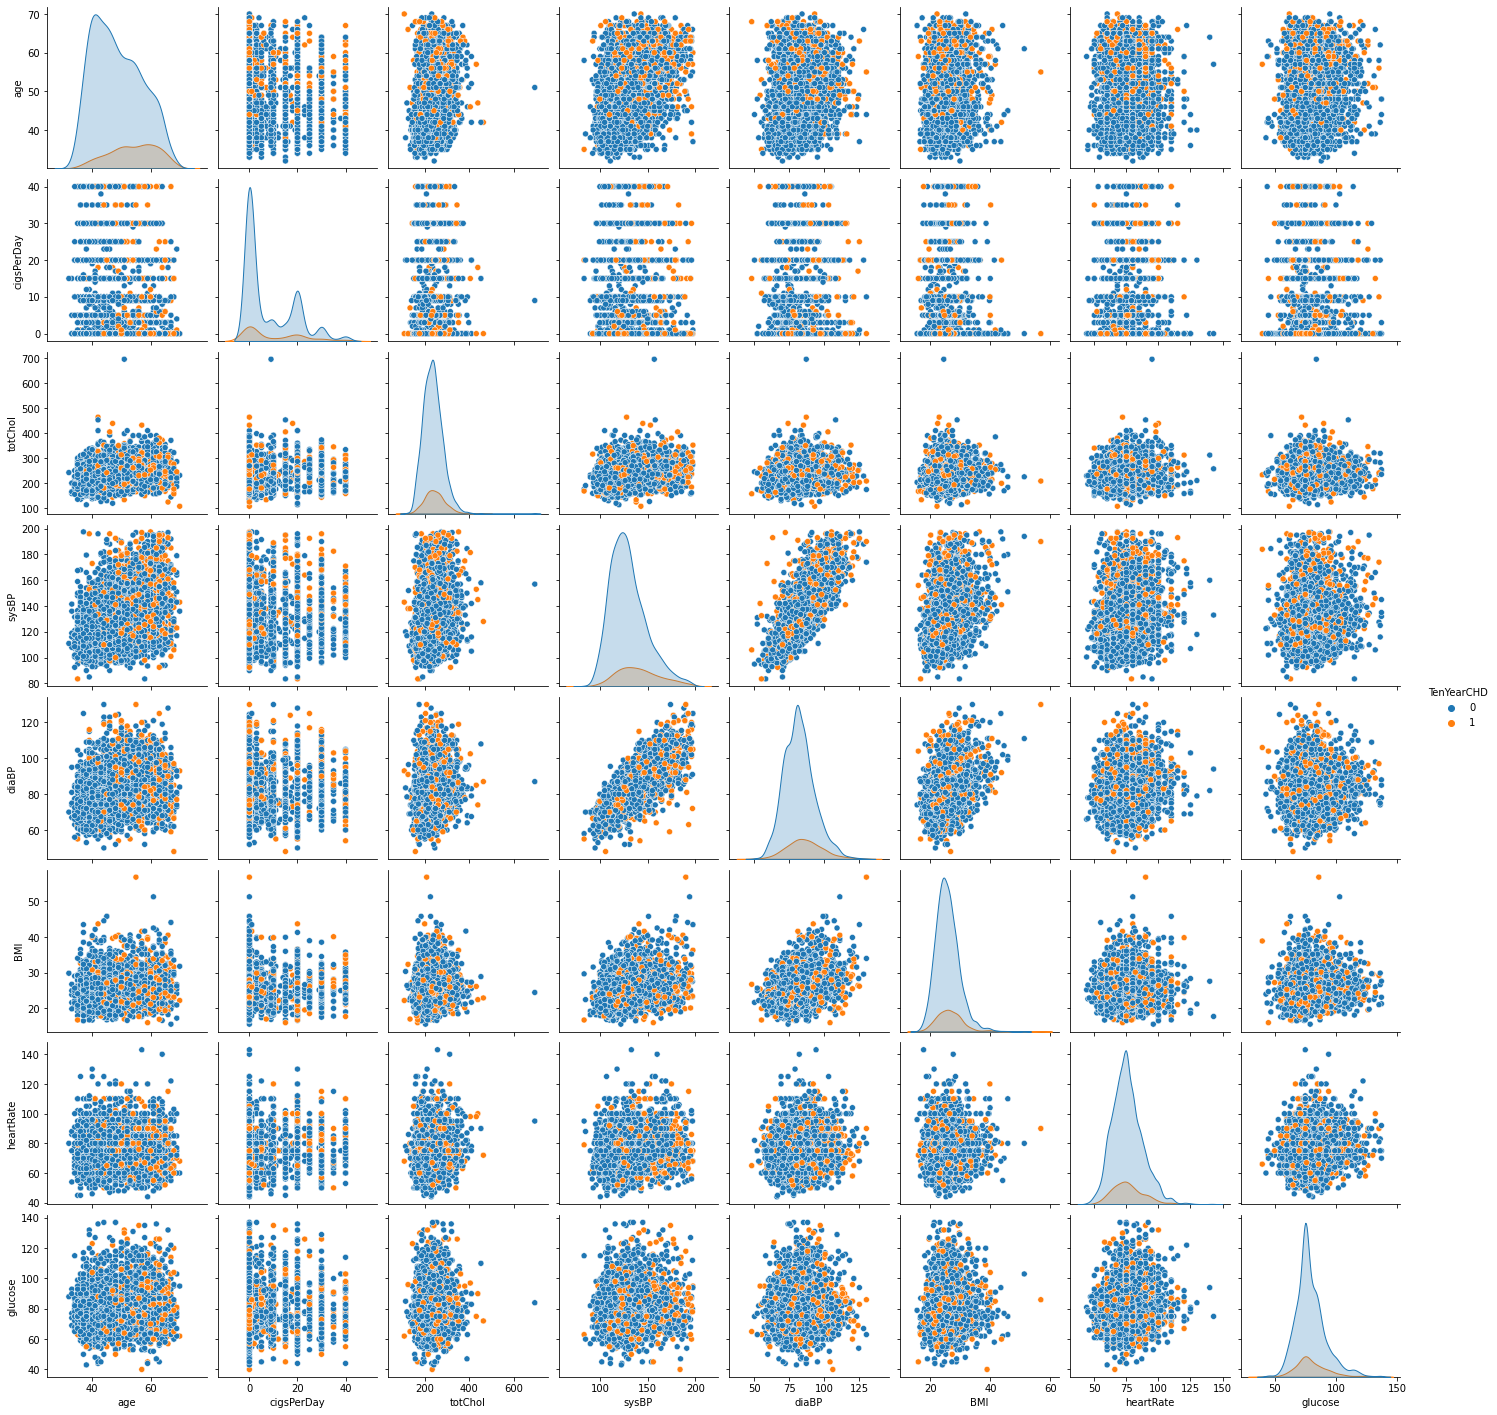

In [35]:
# Multivariate Data Analysis

sns.pairplot(df,diag_kind='kde',hue='TenYearCHD')
plt.show()

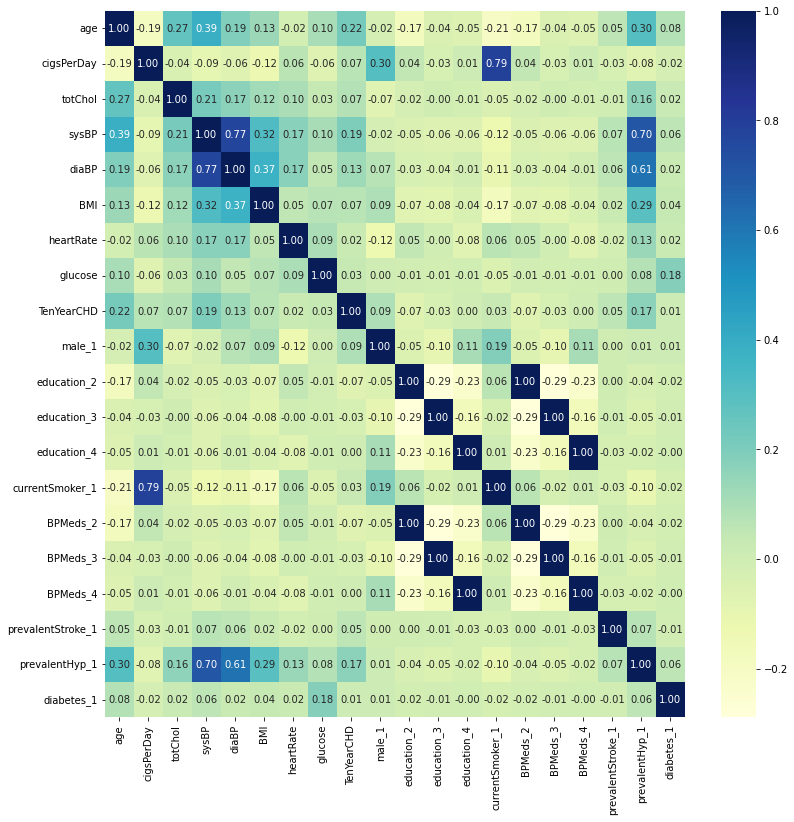

In [36]:
plt.figure(figsize = (13,13))
sns.heatmap(df1.corr(), cmap="YlGnBu", annot = True, fmt='.2f')
plt.show()

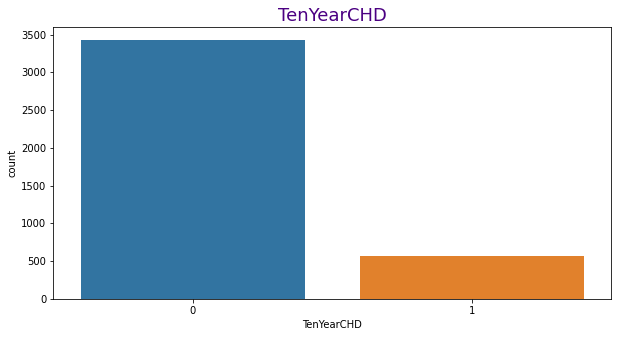

In [37]:
# Plotting Target Variable
plt.figure(figsize=(10,5))
sns.countplot(df['TenYearCHD'])
plt.title("TenYearCHD", fontsize=18, color="indigo")
plt.show()

**This is an imbalanced Dataset so we can try SMOTE in this**

In [38]:
df1.shape

(3995, 20)

In [39]:
X = df1.drop(['TenYearCHD'], axis = 1)
y = df1.TenYearCHD

# Using SMOTE to balance the imbalanced Data Set

In [40]:
#ROC score over imbalanced data

model = LogisticRegression(solver = 'liblinear')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.713


In [41]:
#ROC score after over-sampling minority type of Target Feature 

model = LogisticRegression(solver='liblinear')

print("Shape Before Resampling", X.shape, y.shape)
print("Value count of Target Feature before resampling")
print(y.value_counts(), '\n')

smote = SMOTE(random_state = 1)
X_res, y_res = smote.fit_resample(X, y)

print("Shape After Resampling", X_res.shape, y_res.shape)
print("Value count of Target Feature after resampling")
print(y_res.value_counts())

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_res, y_res, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))                             

Shape Before Resampling (3995, 19) (3995,)
Value count of Target Feature before resampling
0    3428
1     567
Name: TenYearCHD, dtype: int64 

Shape After Resampling (6856, 19) (6856,)
Value count of Target Feature after resampling
0    3428
1    3428
Name: TenYearCHD, dtype: int64
Mean ROC AUC: 0.814


In [42]:
def plot_score(range1, scores):
    plt.plot(range1, scores, linewidth=4)
    plt.title("SMOTE Learning Curve", fontsize=16)
    plt.gca().set_xlabel("# of Points per Class", fontsize=14)
    plt.gca().set_ylabel("Training Accuracy", fontsize=14)
    sns.despine()

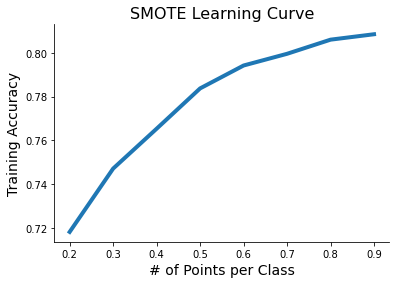

In [43]:
# Determing the learning curve for OverSampling
scores = []
for i in arange(0.2, 1.0, 0.1):
    smote = SMOTE(sampling_strategy = i, random_state = 1)
    X_a, y_a = smote.fit_resample(X, y)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    score = cross_val_score(model, X_a, y_a, scoring='roc_auc', cv=cv, n_jobs=-1)
    scores.append(mean(score))
    
plot_score(arange(0.2, 1.0, 0.1), scores)

**As we oversample and undersample more, the roc_score keeps on increasing**

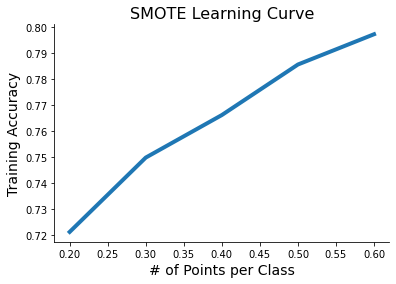

In [44]:
scores1 = []

#Plotting learning curve for Sampling
for i in arange(0.2, 0.7, 0.1):
    if i <= 0.5:
        smote = SMOTE(sampling_strategy = i, random_state = 1)
        X_a, y_a = smote.fit_resample(X, y)
        under = RandomUnderSampler(sampling_strategy = 1 - i, random_state = 1)
        X_b, y_b = under.fit_resample(X_a, y_a)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        score = cross_val_score(model, X_b, y_b, scoring='roc_auc', cv=cv, n_jobs=-1)
        scores1.append(mean(score))
    else:
        if i == 0.6:
            b = 0.9
        else:
            b = 0.8
        smote = SMOTE(sampling_strategy = i, random_state = 1)
        X_a, y_a = smote.fit_resample(X, y)
        under = RandomUnderSampler(sampling_strategy = b, random_state = 1)
        X_b, y_b = under.fit_resample(X_a, y_a)
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        score = cross_val_score(model, X_b, y_b, scoring='roc_auc', cv=cv, n_jobs=-1)
        scores1.append(mean(score))
        
plot_score(arange(0.2, 0.7, 0.1), scores1)

In [45]:
#ROC score after over-sampling minority type and under-sampling of majority type of Target Feature

model = LogisticRegression(solver='liblinear')

print("Shape Before Resampling", X.shape, y.shape)
print("Value count of Target Feature before resampling")
print(y.value_counts())
print('/n')

over = SMOTE(sampling_strategy=0.7, random_state = 1)
X_res, y_res = over.fit_resample(X, y)
print("Shape After Oversampling", X_res.shape, y_res.shape)
print("Value count of Target Feature after Oversampling")
print(y_res.value_counts())
print('/n')

under = RandomUnderSampler(sampling_strategy = 0.8, random_state = 1)
X_res, y_res = under.fit_resample(X_res, y_res)
print("Shape After Undersampling", X_res.shape, y_res.shape)
print("Value count of Target Feature after Undersampling")
print(y_res.value_counts())
print('/n')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_res, y_res, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Shape Before Resampling (3995, 19) (3995,)
Value count of Target Feature before resampling
0    3428
1     567
Name: TenYearCHD, dtype: int64
/n
Shape After Oversampling (5827, 19) (5827,)
Value count of Target Feature after Oversampling
0    3428
1    2399
Name: TenYearCHD, dtype: int64
/n
Shape After Undersampling (5397, 19) (5397,)
Value count of Target Feature after Undersampling
0    2998
1    2399
Name: TenYearCHD, dtype: int64
/n
Mean ROC AUC: 0.801


In [46]:
X = X_res
y = y_res

# Splitting Train Test Data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (4317, 19)
Shape of X_test (1080, 19)
Shape of y_train (4317,)
Shape of y_test (1080,)


In [48]:
final_cols = X_train.columns

# Scaling Data

In [49]:
X_train.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_1,education_2,education_3,education_4,currentSmoker_1,BPMeds_2,BPMeds_3,BPMeds_4,prevalentStroke_1,prevalentHyp_1,diabetes_1
4023,51,24.394481,270.152273,120.697241,73.968830,22.394967,70.605519,86.484415,1,0,0,0,1,0,0,0,0,0,0
4933,49,9.000000,238.406388,109.729940,71.216567,27.170922,73.513373,72.513373,0,0,0,0,1,0,0,0,0,0,0
133,43,0.000000,175.000000,117.000000,67.000000,22.360000,58.000000,70.000000,0,0,0,0,0,0,0,0,0,0,0
5040,51,0.781561,314.747514,181.948930,96.587224,25.963447,65.344682,86.873757,1,0,0,0,0,0,0,0,0,1,0
1364,59,0.000000,229.000000,100.500000,66.000000,25.180000,44.000000,81.000000,1,0,0,0,0,0,0,0,0,0,0


In [50]:
scaler = MinMaxScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Calculating p-values and VIF

In [51]:
# Functions to repeat Logistic regression model and VIF calculations

# Build logistic regression model
def building_log_reg_model(X_train, cols):
    X_train_local = X_train[cols]
    X_train_sm = sm.add_constant(X_train_local)
    log_model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial()).fit()
    return(log_model)

# Calculate VIF
def calculate_VIF(X_train, cols):
    vif = pd.DataFrame()
    vif['Features'] = cols
    vif['VIF'] = [variance_inflation_factor(X_train[cols].values,i) for i in range(X_train[cols].shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by='VIF', ascending = False, inplace=True)  
    return(vif)

In [52]:
log_reg1 = building_log_reg_model(X_train, final_cols)
log_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4300
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2339.1
Date:                Sat, 15 Jan 2022   Deviance:                       4678.2
Time:                        18:46:19   Pearson chi2:                 4.34e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8184      0.243     -7.476      0.000      -2.295      -1.342
age                   2.1396      0.196     10.943      0.000       1.756       2.523
cigsPerDay            2.9862      0.246     12.128      0.000       2.504       3.469
totChol               0.6249      0.300      2.084      0.037       0.037       1.213
sysBP                 1.5981      0.385      4.153      0.000       0.844       2.352
diaBP                 1.3091      0.443      2.954      0.003       0.441       2.178
BMI                  -0.3516      0.406     -0.866      0.387      -1.147       0.444
heartRate            -0.7924      0.318     -2.493      0.013      -1.415      -0.170
glucose               0.1188      0.283      0.419      0.675      -0.437       0.674
male_1               -0.3715      0.081     -4.603      0.000      -0.530      -0.213
education_2          -0.7375      0.048    -15.316      0.000      -0.832      -0.643
education_3          -0.9251      0.067    -13.758      0.000      -1.057      -0.793
education_4          -0.8382      0.077    -10.943      0.000      -0.988      -0.688
currentSmoker_1      -1.0722      0.133     -8.052      0.000      -1.333      -0.811
BPMeds_2             -0.7375      0.048    -15.316      0.000      -0.832      -0.643
BPMeds_3             -0.9251      0.067    -13.758      0.000      -1.057      -0.793
BPMeds_4             -0.8382      0.077    -10.943      0.000      -0.988      -0.688
prevalentStroke_1    -0.3454      0.619     -0.558      0.577      -1.559       0.868
prevalentHyp_1       -0.3987      0.110     -3.637      0.000      -0.613      -0.184
diabetes_1           -1.3083      0.451     -2.898      0.004      -2.193      -0.423
=====================================================================================
"""

In [53]:
calculate_VIF(X_train, final_cols)

,Features,VIF
9,education_2,inf
13,BPMeds_2,inf
15,BPMeds_4,inf
14,BPMeds_3,inf
10,education_3,inf
11,education_4,inf
4,diaBP,28.34
3,sysBP,27.36
7,glucose,9.79
2,totChol,9.72


In [54]:
cols_cols = final_cols.drop(['education_2', 'education_3', 'education_4'])
log_reg2 = building_log_reg_model(X_train, cols_cols)
log_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4300
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2339.1
Date:                Sat, 15 Jan 2022   Deviance:                       4678.2
Time:                        18:46:20   Pearson chi2:                 4.34e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8184      0.243     -7.476      0.000      -2.295      -1.342
age                   2.1396      0.196     10.943      0.000       1.756       2.523
cigsPerDay            2.9862      0.246     12.128      0.000       2.504       3.469
totChol               0.6249      0.300      2.084      0.037       0.037       1.213
sysBP                 1.5981      0.385      4.153      0.000       0.844       2.352
diaBP                 1.3091      0.443      2.954      0.003       0.441       2.178
BMI                  -0.3516      0.406     -0.866      0.387      -1.147       0.444
heartRate            -0.7924      0.318     -2.493      0.013      -1.415      -0.170
glucose               0.1188      0.283      0.419      0.675      -0.437       0.674
male_1               -0.3715      0.081     -4.603      0.000      -0.530      -0.213
currentSmoker_1      -1.0722      0.133     -8.052      0.000      -1.333      -0.811
BPMeds_2             -1.4750      0.096    -15.316      0.000      -1.664      -1.286
BPMeds_3             -1.8502      0.134    -13.758      0.000      -2.114      -1.587
BPMeds_4             -1.6763      0.153    -10.943      0.000      -1.977      -1.376
prevalentStroke_1    -0.3454      0.619     -0.558      0.577      -1.559       0.868
prevalentHyp_1       -0.3987      0.110     -3.637      0.000      -0.613      -0.184
diabetes_1           -1.3083      0.451     -2.898      0.004      -2.193      -0.423
=====================================================================================
"""

In [55]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
4,diaBP,28.34
3,sysBP,27.36
7,glucose,9.79
2,totChol,9.72
5,BMI,8.38
6,heartRate,8.35
0,age,7.46
9,currentSmoker_1,5.48
1,cigsPerDay,5.10
14,prevalentHyp_1,2.79


In [56]:
cols_cols = cols_cols.drop(['glucose'])
log_reg3 = building_log_reg_model(X_train, cols_cols)
log_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4301
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2339.2
Date:                Sat, 15 Jan 2022   Deviance:                       4678.4
Time:                        18:46:21   Pearson chi2:                 4.34e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.7775      0.223     -7.981      0.000      -2.214      -1.341
age                   2.1441      0.195     10.982      0.000       1.761       2.527
cigsPerDay            2.9840      0.246     12.124      0.000       2.502       3.466
totChol               0.6230      0.300      2.078      0.038       0.035       1.211
sysBP                 1.6119      0.383      4.203      0.000       0.860       2.363
diaBP                 1.2970      0.442      2.933      0.003       0.430       2.164
BMI                  -0.3440      0.406     -0.848      0.396      -1.139       0.451
heartRate            -0.7812      0.317     -2.467      0.014      -1.402      -0.160
male_1               -0.3704      0.081     -4.592      0.000      -0.528      -0.212
currentSmoker_1      -1.0737      0.133     -8.066      0.000      -1.335      -0.813
BPMeds_2             -1.4741      0.096    -15.311      0.000      -1.663      -1.285
BPMeds_3             -1.8499      0.134    -13.756      0.000      -2.113      -1.586
BPMeds_4             -1.6759      0.153    -10.942      0.000      -1.976      -1.376
prevalentStroke_1    -0.3455      0.620     -0.557      0.577      -1.560       0.870
prevalentHyp_1       -0.3988      0.110     -3.638      0.000      -0.614      -0.184
diabetes_1           -1.2800      0.446     -2.870      0.004      -2.154      -0.406
=====================================================================================
"""

In [57]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
4,diaBP,28.15
3,sysBP,27.14
2,totChol,9.56
5,BMI,8.18
6,heartRate,7.91
0,age,7.07
8,currentSmoker_1,5.47
1,cigsPerDay,5.10
13,prevalentHyp_1,2.72
7,male_1,1.95


In [58]:
cols_cols = cols_cols.drop(['prevalentHyp_1'])
log_reg4 = building_log_reg_model(X_train, cols_cols)
log_reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4302
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2345.8
Date:                Sat, 15 Jan 2022   Deviance:                       4691.7
Time:                        18:46:22   Pearson chi2:                 4.32e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.4901      0.207     -7.198      0.000      -1.896      -1.084
age                   2.0832      0.194     10.730      0.000       1.703       2.464
cigsPerDay            3.0157      0.246     12.277      0.000       2.534       3.497
totChol               0.6284      0.300      2.097      0.036       0.041       1.216
sysBP                 1.0300      0.347      2.965      0.003       0.349       1.711
diaBP                 1.0649      0.436      2.443      0.015       0.211       1.919
BMI                  -0.3805      0.404     -0.943      0.346      -1.172       0.411
heartRate            -0.8178      0.316     -2.588      0.010      -1.437      -0.198
male_1               -0.3737      0.081     -4.641      0.000      -0.532      -0.216
currentSmoker_1      -1.0870      0.133     -8.174      0.000      -1.348      -0.826
BPMeds_2             -1.4869      0.096    -15.471      0.000      -1.675      -1.299
BPMeds_3             -1.8542      0.134    -13.812      0.000      -2.117      -1.591
BPMeds_4             -1.6875      0.153    -11.046      0.000      -1.987      -1.388
prevalentStroke_1    -0.3758      0.627     -0.600      0.549      -1.604       0.852
diabetes_1           -1.3385      0.446     -3.002      0.003      -2.212      -0.465
=====================================================================================
"""

In [59]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
4,diaBP,28.13
3,sysBP,22.18
2,totChol,9.38
5,BMI,8.14
6,heartRate,7.83
0,age,7.05
8,currentSmoker_1,5.46
1,cigsPerDay,5.09
7,male_1,1.95
9,BPMeds_2,1.41


In [60]:
cols_cols = cols_cols.drop(['diaBP'])
log_reg5 = building_log_reg_model(X_train, cols_cols)
log_reg5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4303
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2348.8
Date:                Sat, 15 Jan 2022   Deviance:                       4697.7
Time:                        18:46:23   Pearson chi2:                 4.32e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.3215      0.195     -6.791      0.000      -1.703      -0.940
age                   1.9631      0.187     10.488      0.000       1.596       2.330
cigsPerDay            3.0071      0.246     12.236      0.000       2.525       3.489
totChol               0.6278      0.300      2.094      0.036       0.040       1.215
sysBP                 1.6790      0.226      7.433      0.000       1.236       2.122
BMI                  -0.2059      0.397     -0.518      0.604      -0.985       0.573
heartRate            -0.7515      0.315     -2.388      0.017      -1.368      -0.135
male_1               -0.3464      0.080     -4.351      0.000      -0.502      -0.190
currentSmoker_1      -1.1054      0.133     -8.318      0.000      -1.366      -0.845
BPMeds_2             -1.4846      0.096    -15.466      0.000      -1.673      -1.296
BPMeds_3             -1.8441      0.134    -13.763      0.000      -2.107      -1.582
BPMeds_4             -1.6740      0.152    -10.985      0.000      -1.973      -1.375
prevalentStroke_1    -0.3758      0.631     -0.595      0.552      -1.613       0.862
diabetes_1           -1.3667      0.447     -3.057      0.002      -2.243      -0.490
=====================================================================================
"""

In [61]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
3,sysBP,9.35
2,totChol,9.21
5,heartRate,7.47
4,BMI,7.44
0,age,6.93
7,currentSmoker_1,5.45
1,cigsPerDay,5.09
6,male_1,1.88
8,BPMeds_2,1.40
9,BPMeds_3,1.20


In [62]:
cols_cols = cols_cols.drop(['BMI'])
log_reg6 = building_log_reg_model(X_train, cols_cols)
log_reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4304
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2349.0
Date:                Sat, 15 Jan 2022   Deviance:                       4697.9
Time:                        18:46:24   Pearson chi2:                 4.32e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.3596      0.180     -7.541      0.000      -1.713      -1.006
age                   1.9672      0.187     10.521      0.000       1.601       2.334
cigsPerDay            3.0097      0.246     12.250      0.000       2.528       3.491
totChol               0.6194      0.299      2.069      0.039       0.033       1.206
sysBP                 1.6511      0.219      7.531      0.000       1.221       2.081
heartRate            -0.7569      0.315     -2.406      0.016      -1.373      -0.140
male_1               -0.3504      0.079     -4.423      0.000      -0.506      -0.195
currentSmoker_1      -1.0998      0.132     -8.306      0.000      -1.359      -0.840
BPMeds_2             -1.4806      0.096    -15.479      0.000      -1.668      -1.293
BPMeds_3             -1.8390      0.134    -13.764      0.000      -2.101      -1.577
BPMeds_4             -1.6708      0.152    -10.973      0.000      -1.969      -1.372
prevalentStroke_1    -0.3733      0.632     -0.590      0.555      -1.613       0.866
diabetes_1           -1.3748      0.447     -3.077      0.002      -2.251      -0.499
=====================================================================================
"""

In [63]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
2,totChol,8.71
3,sysBP,8.38
4,heartRate,7.11
0,age,6.88
6,currentSmoker_1,5.45
1,cigsPerDay,5.08
5,male_1,1.81
7,BPMeds_2,1.40
8,BPMeds_3,1.20
9,BPMeds_4,1.16


In [64]:
cols_cols = cols_cols.drop(['totChol'])
log_reg7 = building_log_reg_model(X_train, cols_cols)
log_reg7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4305
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2351.1
Date:                Sat, 15 Jan 2022   Deviance:                       4702.2
Time:                        18:46:25   Pearson chi2:                 4.33e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.1932      0.161     -7.420      0.000      -1.508      -0.878
age                   2.0263      0.185     10.966      0.000       1.664       2.388
cigsPerDay            3.0202      0.246     12.299      0.000       2.539       3.502
sysBP                 1.6926      0.218      7.759      0.000       1.265       2.120
heartRate            -0.7058      0.313     -2.254      0.024      -1.319      -0.092
male_1               -0.3653      0.079     -4.629      0.000      -0.520      -0.211
currentSmoker_1      -1.1012      0.132     -8.324      0.000      -1.361      -0.842
BPMeds_2             -1.4713      0.095    -15.416      0.000      -1.658      -1.284
BPMeds_3             -1.8228      0.133    -13.682      0.000      -2.084      -1.562
BPMeds_4             -1.6559      0.152    -10.895      0.000      -1.954      -1.358
prevalentStroke_1    -0.3975      0.634     -0.627      0.531      -1.641       0.846
diabetes_1           -1.3714      0.447     -3.071      0.002      -2.247      -0.496
=====================================================================================
"""

In [65]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
2,sysBP,7.88
3,heartRate,6.31
0,age,5.93
5,currentSmoker_1,5.43
1,cigsPerDay,5.08
4,male_1,1.80
6,BPMeds_2,1.37
7,BPMeds_3,1.17
8,BPMeds_4,1.14
9,prevalentStroke_1,1.01


In [66]:
cols_cols = cols_cols.drop(['sysBP'])
log_reg8 = building_log_reg_model(X_train, cols_cols)
log_reg8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4306
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2381.8
Date:                Sat, 15 Jan 2022   Deviance:                       4763.6
Time:                        18:46:26   Pearson chi2:                 4.35e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.7731      0.150     -5.166      0.000      -1.066      -0.480
age                   2.5119      0.174     14.449      0.000       2.171       2.853
cigsPerDay            3.0919      0.244     12.649      0.000       2.613       3.571
heartRate            -0.2823      0.305     -0.925      0.355      -0.881       0.316
male_1               -0.3765      0.078     -4.803      0.000      -0.530      -0.223
currentSmoker_1      -1.1798      0.131     -8.989      0.000      -1.437      -0.923
BPMeds_2             -1.4758      0.095    -15.583      0.000      -1.661      -1.290
BPMeds_3             -1.8689      0.132    -14.129      0.000      -2.128      -1.610
BPMeds_4             -1.7046      0.151    -11.267      0.000      -2.001      -1.408
prevalentStroke_1    -0.1612      0.622     -0.259      0.795      -1.380       1.057
diabetes_1           -1.2875      0.444     -2.900      0.004      -2.158      -0.417
=====================================================================================
"""

In [67]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
4,currentSmoker_1,5.42
1,cigsPerDay,5.07
2,heartRate,5.03
0,age,3.72
3,male_1,1.80
5,BPMeds_2,1.36
6,BPMeds_3,1.17
7,BPMeds_4,1.14
8,prevalentStroke_1,1.01
9,diabetes_1,1.01


In [68]:
cols_cols = cols_cols.drop(['prevalentStroke_1'])
log_reg9 = building_log_reg_model(X_train, cols_cols)
log_reg9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4307
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2381.8
Date:                Sat, 15 Jan 2022   Deviance:                       4763.7
Time:                        18:46:27   Pearson chi2:                 4.35e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.7732      0.150     -5.166      0.000      -1.066      -0.480
age                 2.5101      0.174     14.450      0.000       2.170       2.851
cigsPerDay          3.0924      0.244     12.652      0.000       2.613       3.572
heartRate          -0.2809      0.305     -0.920      0.357      -0.879       0.317
male_1             -0.3767      0.078     -4.805      0.000      -0.530      -0.223
currentSmoker_1    -1.1799      0.131     -8.991      0.000      -1.437      -0.923
BPMeds_2           -1.4761      0.095    -15.589      0.000      -1.662      -1.291
BPMeds_3           -1.8687      0.132    -14.128      0.000      -2.128      -1.609
BPMeds_4           -1.7040      0.151    -11.264      0.000      -2.001      -1.408
diabetes_1         -1.2867      0.444     -2.898      0.004      -2.157      -0.417
===================================================================================
"""

In [69]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
4,currentSmoker_1,5.42
1,cigsPerDay,5.07
2,heartRate,5.03
0,age,3.70
3,male_1,1.80
5,BPMeds_2,1.36
6,BPMeds_3,1.17
7,BPMeds_4,1.14
8,diabetes_1,1.01


In [70]:
cols_cols = cols_cols.drop(['heartRate'])
log_reg10 = building_log_reg_model(X_train, cols_cols)
log_reg10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             TenYearCHD   No. Observations:                 4317
Model:                            GLM   Df Residuals:                     4308
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2382.3
Date:                Sat, 15 Jan 2022   Deviance:                       4764.5
Time:                        18:46:28   Pearson chi2:                 4.35e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.8630      0.114     -7.601      0.000      -1.086      -0.640
age                 2.5104      0.174     14.454      0.000       2.170       2.851
cigsPerDay          3.0777      0.244     12.621      0.000       2.600       3.556
male_1             -0.3665      0.078     -4.724      0.000      -0.519      -0.214
currentSmoker_1    -1.1819      0.131     -9.005      0.000      -1.439      -0.925
BPMeds_2           -1.4780      0.095    -15.612      0.000      -1.664      -1.292
BPMeds_3           -1.8678      0.132    -14.125      0.000      -2.127      -1.609
BPMeds_4           -1.6972      0.151    -11.239      0.000      -1.993      -1.401
diabetes_1         -1.2908      0.444     -2.909      0.004      -2.161      -0.421
===================================================================================
"""

In [71]:
calculate_VIF(X_train, cols_cols)

,Features,VIF
3,currentSmoker_1,5.30
1,cigsPerDay,5.03
2,male_1,1.79
0,age,1.70
4,BPMeds_2,1.25
5,BPMeds_3,1.13
6,BPMeds_4,1.12
7,diabetes_1,1.01


<AxesSubplot:>

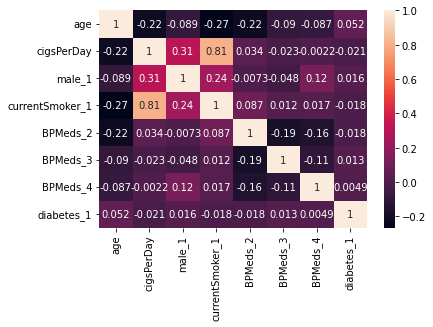

In [72]:
sns.heatmap(X_train[cols_cols].corr(), annot=True)

# Model Evaluation

In [73]:
log_reg_final = log_reg10
X_train_final = X_train[cols_cols]

X_train_sm = sm.add_constant(X_train_final)
y_train_pred = log_reg_final.predict(X_train_sm).values
y_train_pred

array([0.6652515 , 0.43367694, 0.45399341, ..., 0.70919029, 0.06959772,
       0.57750229])

In [74]:
y_train_pred_df = pd.DataFrame()
y_train_pred_df['CHD Positive'] = y_train.values
y_train_pred_df['CHD Predict Prob'] = y_train_pred
y_train_pred_df['CHD Predicted'] = y_train_pred_df['CHD Predict Prob'].map(lambda x : 1 if x > 0.5 else 0)
y_train_pred_df.head()

,CHD Positive,CHD Predict Prob,CHD Predicted
0,1,0.665252,1
1,1,0.433677,0
2,0,0.453993,0
3,1,0.512958,1
4,0,0.630532,1


In [75]:
# Checking Training Accuracy Score
accuracy_score(y_true= y_train_pred_df['CHD Positive'], y_pred= y_train_pred_df['CHD Predicted'])

0.7280518878851054

In [76]:
cf_matrix = confusion_matrix(y_true= y_train_pred_df['CHD Positive'], y_pred= y_train_pred_df['CHD Predicted'])
cf_matrix

array([[1773,  631],
       [ 543, 1370]])

In [77]:
TP = cf_matrix[1,1] 
TN = cf_matrix[0,0] 
FP = cf_matrix[0,1] 
FN = cf_matrix[1,0] 

print("Sensitivity =", (TP/(TP+FN)).round(2))
print("Specificity =", (TN/(TN+FP)).round(2))
print("False Positive Rate =", (FP/(TN+FP)).round(2))
print("Positive Predictive Power =", (TP/(TP+FP)).round(2))
print("Negative Predictive Power =", (TN/(TN+ FN)).round(2))

Sensitivity = 0.72
Specificity = 0.74
False Positive Rate = 0.26
Positive Predictive Power = 0.68
Negative Predictive Power = 0.77


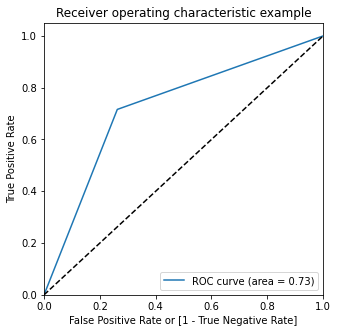

In [78]:
#ROC Curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
draw_roc(y_train_pred_df['CHD Positive'],y_train_pred_df['CHD Predicted'])

In [79]:
range_ = arange(0.0, 1.0, 0.1)

for i in range_:
    col_name = "CutOff="+ str(i.round(1))
    y_train_pred_df[col_name] = y_train_pred_df['CHD Predict Prob'].map(lambda x : 1 if x > i else 0)

y_train_pred_df.head()

,CHD Positive,CHD Predict Prob,CHD Predicted,CutOff=0.0,CutOff=0.1,CutOff=0.2,CutOff=0.3,CutOff=0.4,CutOff=0.5,CutOff=0.6,CutOff=0.7,CutOff=0.8,CutOff=0.9
0,1,0.665252,1,1,1,1,1,1,1,1,0,0,0
1,1,0.433677,0,1,1,1,1,1,0,0,0,0,0
2,0,0.453993,0,1,1,1,1,1,0,0,0,0,0
3,1,0.512958,1,1,1,1,1,1,1,0,0,0,0
4,0,0.630532,1,1,1,1,1,1,1,1,0,0,0


In [80]:
cutoff_df = pd.DataFrame(columns = ['Cutoff','Accuracy','Sensitivity','Specificity'])

for i in range_:
    col_name = "CutOff="+ str(i.round(1))
    cf_mat =  confusion_matrix(y_true= y_train_pred_df['CHD Positive'], y_pred= y_train_pred_df[col_name])
    total=sum(sum(cf_mat))
    accuracy = (cf_mat[0,0]+cf_mat[1,1])/total
    speci = cf_mat[0,0]/(cf_mat[0,0]+cf_mat[0,1])
    sensi = cf_mat[1,1]/(cf_mat[1,0]+cf_mat[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    
cutoff_df

,Cutoff,Accuracy,Sensitivity,Specificity
0.0,0.0,0.443132,1.000000,0.000000
0.1,0.1,0.520269,0.989022,0.147255
0.2,0.2,0.625666,0.923157,0.388935
0.3,0.3,0.678712,0.864088,0.531198
0.4,0.4,0.713458,0.810246,0.636439
0.5,0.5,0.728052,0.716153,0.737521
0.6,0.6,0.711142,0.562467,0.829451
0.7,0.7,0.664119,0.344485,0.918469
0.8,0.8,0.581886,0.070047,0.989185
0.9,0.9,0.561501,0.011500,0.999168


<Figure size 1296x1296 with 0 Axes>

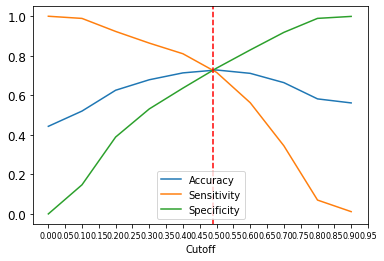

In [81]:
# Plotting - Accuracy , Sensitivity and specificity
plt.figure(figsize=(18,18))
cutoff_df.plot.line(x='Cutoff', y=['Accuracy','Sensitivity','Specificity'])
plt.xticks(np.arange(0,1,step=0.05),size=8)
plt.axvline(x=0.49, color='r', linestyle='--') # additing axline
plt.yticks(size=12)
plt.show()

In [82]:
y_train_pred_df['CHD Predicted'] = y_train_pred_df['CHD Predict Prob'].map(lambda x : 1 if x > 0.49 else 0)
y_train_pred_df.head()

,CHD Positive,CHD Predict Prob,CHD Predicted,CutOff=0.0,CutOff=0.1,CutOff=0.2,CutOff=0.3,CutOff=0.4,CutOff=0.5,CutOff=0.6,CutOff=0.7,CutOff=0.8,CutOff=0.9
0,1,0.665252,1,1,1,1,1,1,1,1,0,0,0
1,1,0.433677,0,1,1,1,1,1,0,0,0,0,0
2,0,0.453993,0,1,1,1,1,1,0,0,0,0,0
3,1,0.512958,1,1,1,1,1,1,1,0,0,0,0
4,0,0.630532,1,1,1,1,1,1,1,1,0,0,0


In [83]:
accuracy_score(y_train_pred_df['CHD Positive'], y_train_pred_df['CHD Predicted'])

0.7287468149177669

In [84]:
cf_matrix = confusion_matrix(y_true= y_train_pred_df['CHD Positive'], y_pred= y_train_pred_df['CHD Predicted'])
cf_matrix

array([[1754,  650],
       [ 521, 1392]])

In [85]:
TP = cf_matrix[1,1] 
TN = cf_matrix[0,0] 
FP = cf_matrix[0,1] 
FN = cf_matrix[1,0] 

print("Sensitivity =", (TP/(TP+FN)).round(2))
print("Specificity =", (TN/(TN+FP)).round(2))
print("False Positive Rate =", (FP/(TN+FP)).round(2))
print("Positive Predictive Power =", (TP/(TP+FP)).round(2))
print("Negative Predictive Power =", (TN/(TN+ FN)).round(2))

Sensitivity = 0.73
Specificity = 0.73
False Positive Rate = 0.27
Positive Predictive Power = 0.68
Negative Predictive Power = 0.77


# Test Data Prediction

In [86]:
X_test_final = X_test[cols_cols]
X_test.head()

,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose,male_1,education_2,education_3,education_4,currentSmoker_1,BPMeds_2,BPMeds_3,BPMeds_4,prevalentStroke_1,prevalentHyp_1,diabetes_1
3865,0.729730,0.500,0.300951,0.273935,0.300489,0.235122,0.220614,0.218806,1,0,0,0,1,0,0,0,0,0,0
929,0.783784,0.125,0.380952,0.644737,0.585366,0.315132,0.313131,0.319588,1,0,0,0,1,0,0,0,0,1,0
4888,0.702703,0.000,0.292677,0.504493,0.493481,0.370503,0.277921,0.283442,1,0,0,0,0,0,0,0,0,1,0
206,0.216216,0.225,0.204482,0.267544,0.268293,0.157933,0.484848,0.360825,0,1,0,0,1,1,0,0,1,1,0
4675,0.540541,0.500,0.525613,0.528750,0.518878,0.256653,0.602324,0.334557,0,0,0,0,1,0,0,0,0,1,0


In [87]:
X_test_sm = sm.add_constant(X_test_final)

y_test_pred = log_reg_final.predict(X_test_sm).values
y_test_pred

array([0.72298235, 0.48522079, 0.63053167, ..., 0.07631077, 0.11613093,
       0.62699337])

In [88]:
y_test_pred_df = pd.DataFrame()
y_test_pred_df['CHD Positive'] = y_test.values
y_test_pred_df['CHD Predict Prob'] = y_test_pred
y_test_pred_df['CHD Predicted'] = y_test_pred_df['CHD Predict Prob'].map(lambda x : 1 if x > 0.49 else 0)
y_test_pred_df.head()

,CHD Positive,CHD Predict Prob,CHD Predicted
0,1,0.722982,1
1,0,0.485221,0
2,1,0.630532,1
3,0,0.092147,0
4,1,0.700755,1


In [89]:
# Checking Testing Accuracy Score
accuracy_score(y_true= y_test_pred_df['CHD Positive'], y_pred= y_test_pred_df['CHD Predicted'])

0.7453703703703703

In [90]:
#Confusion Matrix
cf_matrix = confusion_matrix(y_true= y_test_pred_df['CHD Positive'], y_pred= y_test_pred_df['CHD Predicted'])
cf_matrix

array([[439, 155],
       [120, 366]])

In [91]:
TP = cf_matrix[1,1] 
TN = cf_matrix[0,0] 
FP = cf_matrix[0,1] 
FN = cf_matrix[1,0] 

print("Sensitivity =", (TP/(TP+FN)).round(2))
print("Specificity =", (TN/(TN+FP)).round(2))
print("False Positive Rate =", (FP/(TN+FP)).round(2))
print("Positive Predictive Power =", (TP/(TP+FP)).round(2))
print("Negative Predictive Power =", (TN/(TN+ FN)).round(2))

Sensitivity = 0.75
Specificity = 0.74
False Positive Rate = 0.26
Positive Predictive Power = 0.7
Negative Predictive Power = 0.79
